# <font color='#922B21'><b><center> DIGIT CLASSIFICATION </font> </b> </center>

## <font color='#7D3C98'>Table of Contents</font>

1. [Problem Statement](#1)
2. [Modules](#2)
3. [Helper Functions](#3)
4. [Loading, exploring and pre-processing data](#4)
5. [Model Selection](#5)
6. [Hyperparameter Tunnig](#6)
7. [Making predictions](#7)
8. [Analysis](#8)

<a name="1"></a>
## <font color='red'> <b> 1. Problem Statement </font> </b>

We're gonna classify handwriiten digits from 0 to 9.

<a name="2"></a>
## <font color='red'> <b> 2. Modules </font> </b>

In [5]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import warnings
warnings.filterwarnings('ignore')

In [111]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import keras_tuner
import random


<a name="3"></a>
## <font color='red'> <b> 3. Helper Functions </font> </b>

In [67]:

# plot random images
def plot_random_images(figsize=(6,6)):
    plt.figure(figsize=figsize)
    for i in range(4):
      ax = plt.subplot(2, 2, i+1)
      rand_index = random.choice(range(len(train_data)))
      plt.imshow(train_data[rand_index], cmap=plt.cm.binary)
      plt.title(class_names[train_labels[rand_index]])
      plt.axis(False)
    
    
    
# plot history
def plot_history(history, x_label_one, y_label_one, x_label_two, y_label_two):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel(x_label_one)
    plt.ylabel(y_label_one)
    plt.plot(hist['epoch'], hist['loss'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Val Error')
    #plt.ylim([0,5])
    plt.legend()

    plt.figure()
    plt.xlabel(x_label_two)
    plt.ylabel(y_label_two)
    plt.plot(hist['epoch'], hist['accuracy'],
           label='Train Accuracy')
    plt.plot(hist['epoch'], hist['val_accuracy'],
           label = 'Val Accuracy')
    #plt.ylim([0,20])
    plt.legend()
    plt.show()
    
    
    
# confussion matrix
def plot_confusion_matrix_tf(y_test,y_pred,labels,figsize=(10,8)):
    plt.figure(figsize=figsize)
    confusion_mtx = tf.math.confusion_matrix(y_test,y_pred)
    sns.heatmap(confusion_mtx,
                xticklabels=labels,
                yticklabels=labels,
                annot=True, fmt='g')
    plt.xlabel('Prediction')
    plt.ylabel('Label')
    plt.show()

<a name="4"></a>
## <font color='red'> <b> 4. Loading, exploring and pre-processing data </font> </b>


In [10]:
(train_data, train_labels), (test_data, test_labels) = mnist.load_data()

In [21]:
# let's explore a little

print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")
print(f"Train labels shape: {train_labels.shape}")
print(f"Test labels shape: {test_labels.shape}")
print(f"Min and max values in training data {train_data.min()} , {train_data.max()}")

Train data shape: (60000, 28, 28)
Test data shape: (10000, 28, 28)
Train labels shape: (60000,)
Test labels shape: (10000,)
Min and max values in training data 0 , 255


We can see, for example, that in the training set, we have 60,000 images of size 28x28 with values ranging from 0 to 255.

Let's see an example.

In [13]:
train_data[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

In [15]:
train_labels[:3] # first three

array([5, 0, 4], dtype=uint8)

The labels are integers (ranging from 0 to 9).

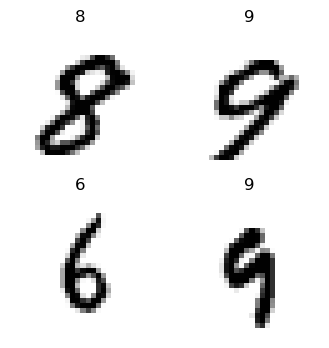

In [31]:
# plot some random images
plot_random_images((4,4))

In [19]:
# define class labels
class_names = [0,1,2,3,4,5,6,7,8,9]

In [22]:
# normalize
train_data = train_data/255.0
test_data = test_data/255.0

In [24]:
# check
train_data.min() ,train_data.max(), test_data.min() , test_data.max()

(0.0, 1.0, 0.0, 1.0)

<a name="5"></a>
## <font color='red'> <b> 5. Model Selection </font> </b>

In [33]:
# random seed
tf.random.set_seed(42)

In [39]:
INPUT_SHAPE = train_data[1].shape # iamge size
OUTPUT_SHAPE = len(class_names) # 10 digits
INITIAL_LR = 0.001

INPUT_SHAPE, OUTPUT_SHAPE


((28, 28), 10)

Since our labels are integers, for the loss function, we're going to use Sparse Categorical Crossentropy.

### Model 1

In [38]:
def build_model(input_shape,output_shape,initial_lr):
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=input_shape),
        tf.keras.layers.Dense(128,activation='relu'),
        tf.keras.layers.Dense(128,activation='relu'),
        tf.keras.layers.Dense(128,activation='relu'),
        tf.keras.layers.Dense(output_shape,activation='softmax')
    ])
    
    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr),
        metrics=['accuracy']
    )
    
    return model

In [42]:
model_one = build_model(INPUT_SHAPE, OUTPUT_SHAPE, INITIAL_LR)
model_one.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 784)               0         
                                                                 
 dense_12 (Dense)            (None, 128)               100480    
                                                                 
 dense_13 (Dense)            (None, 128)               16512     
                                                                 
 dense_14 (Dense)            (None, 128)               16512     
                                                                 
 dense_15 (Dense)            (None, 10)                1290      
                                                                 
Total params: 134794 (526.54 KB)
Trainable params: 134794 (526.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [70]:
# learning rate scheduler as a callback
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch, lr: lr if epoch < 5 else lr * tf.math.exp(-0.1))


# fit
model_one_history = model_one.fit(
        train_data,
        train_labels,
        validation_split=0.2,
        epochs=8,
        verbose=0,
        callbacks=[lr_scheduler] 
    )

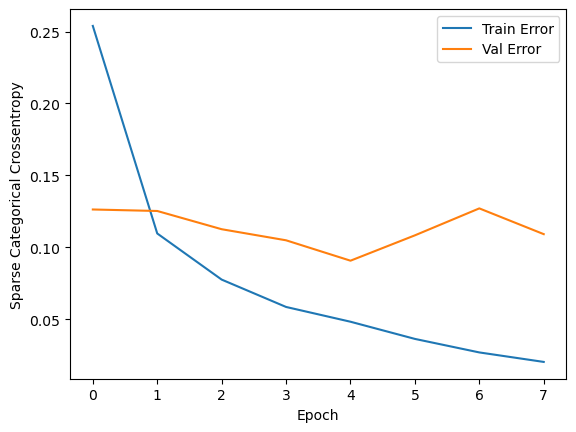

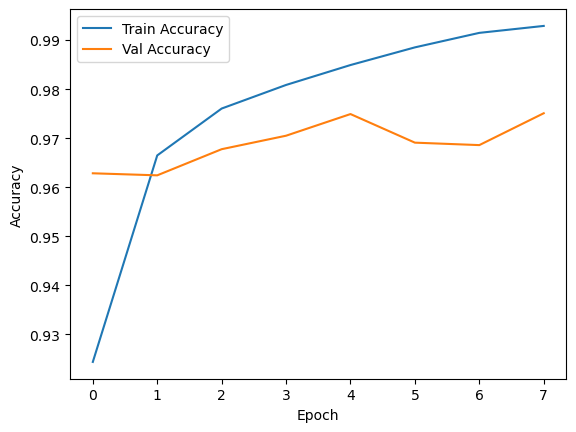

In [48]:
plot_history(model_one_history, 'Epoch', 'Sparse Categorical Crossentropy', 'Epoch', 'Accuracy')

In [55]:
model_one.evaluate(test_data, test_labels)

313/313 [==============================] - 0s 1ms/step - loss: 0.0967 - accuracy: 0.9776


[0.09667246788740158, 0.9775999784469604]

We can observe that the model is overfitting. Therefore, we're going to add dropout layers for regularization.

### Model 2

In [49]:
# construcción del modelo
def build_model_two(input_shape,output_shape,initial_lr):
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=input_shape),
        tf.keras.layers.Dense(128,activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128,activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128,activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(output_shape,activation='softmax')
    ])
    
    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr),
        metrics=['accuracy']
    )
    
    return model

In [51]:
model_two = build_model_two(INPUT_SHAPE, OUTPUT_SHAPE, INITIAL_LR)
model_two.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 784)               0         
                                                                 
 dense_20 (Dense)            (None, 128)               100480    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_21 (Dense)            (None, 128)               16512     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_22 (Dense)            (None, 128)               16512     
                                                                 
 dropout_5 (Dropout)         (None, 128)              

In [69]:
# learning rate scheduler as a callback
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch, lr: lr if epoch < 5 else lr * tf.math.exp(-0.1))


# fit
model_two_history = model_two.fit(
        train_data,
        train_labels,
        validation_split=0.2,
        epochs=8,
        verbose=0,
        callbacks=[lr_scheduler] 
    )

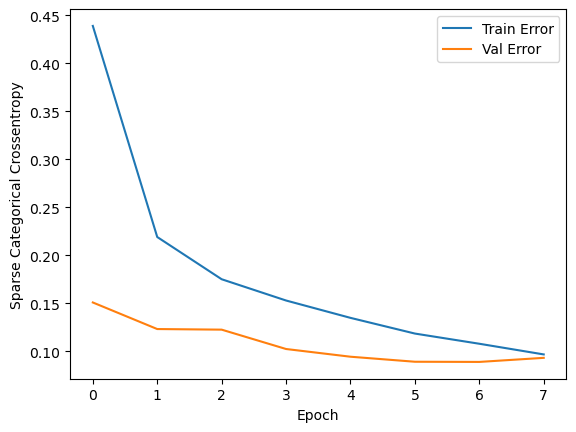

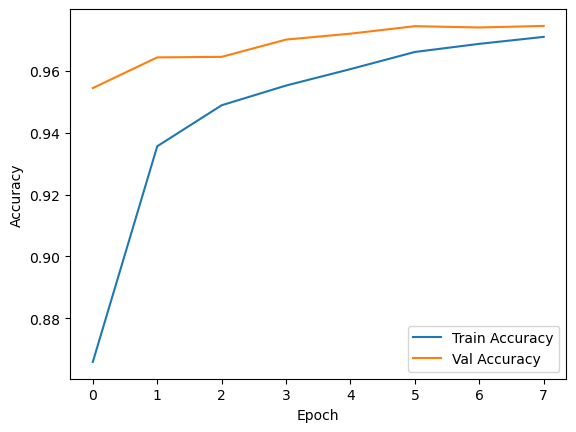

In [53]:
plot_history(model_two_history, 'Epoch', 'Sparse Categorical Crossentropy', 'Epoch', 'Accuracy')

In [56]:
model_two.evaluate(test_data, test_labels)

313/313 [==============================] - 0s 1ms/step - loss: 0.0819 - accuracy: 0.9759


[0.0819445550441742, 0.9758999943733215]

<a name="6"></a>
## <font color='red'> <b> 6. Hyperparameter tunning </font> </b>

In [60]:
def build_model(hp,input_shape, output_shape, initial_lr):
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=input_shape),
        tf.keras.layers.Dense(hp.Choice('units1', [128,256, 512]),activation='relu'),
        tf.keras.layers.Dropout(hp.Choice('rate1', [0.1, 0.3,0.5])),
        tf.keras.layers.Dense(hp.Choice('units2', [128,256, 512]),activation='relu'),
        tf.keras.layers.Dropout(hp.Choice('rate2', [0.1, 0.3,0.5])),
        tf.keras.layers.Dense(hp.Choice('units3', [128,256, 512]),activation='relu'),
        tf.keras.layers.Dropout(hp.Choice('rate3', [0.1, 0.3,0.5])),
        tf.keras.layers.Dense(output_shape,activation='softmax')
    ])
    
    initial_lr = hp.Choice("learning_rate",values=[1e-1, 1e-2, 1e-3])
    opt = tf.keras.optimizers.Adam(learning_rate=initial_lr)
    
    
    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        optimizer=opt,
        metrics=['accuracy']
    )
    
    return model

In [61]:
tuner = keras_tuner.BayesianOptimization(
        lambda hp:build_model(hp, INPUT_SHAPE, OUTPUT_SHAPE, INITIAL_LR),
        objective='val_loss',
        max_trials=5,
        directory='my_tuning_directory',
        project_name='digit_classification'
)

In [62]:
tuner.search(train_data, train_labels, epochs=5,validation_split=0.2) 

Trial 5 Complete [00h 00m 45s]
val_loss: 2.305152177810669

Best val_loss So Far: 0.0910431444644928
Total elapsed time: 00h 03m 49s
INFO:tensorflow:Oracle triggered exit


In [63]:
tuner.results_summary(1)

Results summary
Results in my_tuning_directory/digit_classification
Showing 1 best trials
Objective(name="val_loss", direction="min")

Trial 2 summary
Hyperparameters:
units1: 512
rate1: 0.1
units2: 512
rate2: 0.5
units3: 256
rate3: 0.5
learning_rate: 0.001
Score: 0.0910431444644928


In [64]:
# re-training with the best hyperparameters

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
final_model = tuner.hypermodel.build(best_hps)

final_history = final_model.fit(train_data, train_labels, epochs=8,validation_split=0.2,verbose=0)

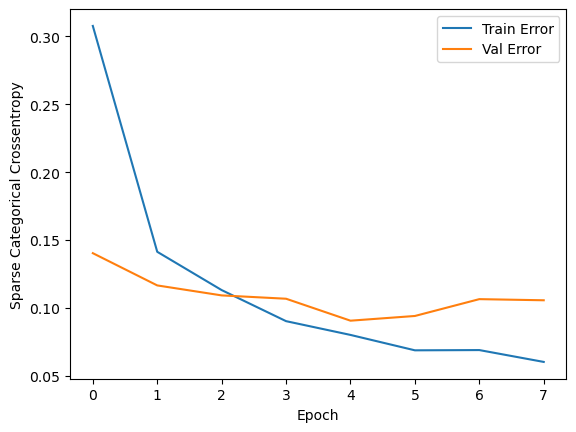

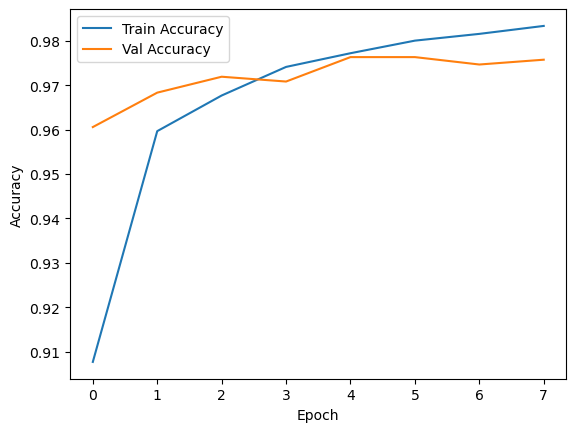

In [65]:
plot_history(final_history, 'Epoch', 'Sparse Categorical Crossentropy', 'Epoch', 'Accuracy')

In [66]:
final_model.evaluate(test_data, test_labels)

313/313 [==============================] - 1s 2ms/step - loss: 0.0895 - accuracy: 0.9786


[0.08947525918483734, 0.978600025177002]

Let's see the confussion matrix.

313/313 [==============================] - 1s 2ms/step


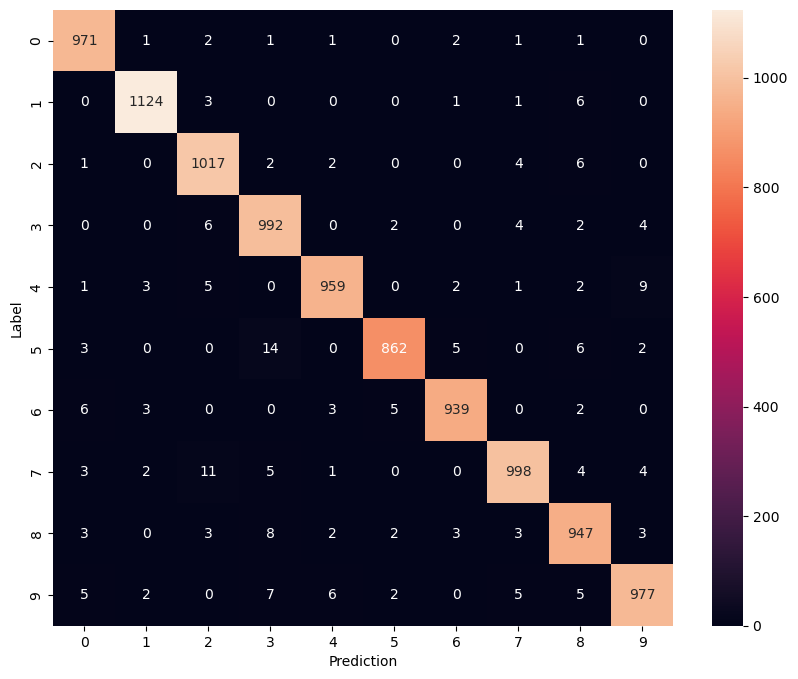

In [68]:
y_probs = final_model.predict(test_data) # the outputs are probabilities
y_preds = y_probs.argmax(axis=1)

plot_confusion_matrix_tf(test_labels,y_preds,class_names)

<a name="7"></a>
## <font color='red'> <b> 7. Making predictions </font> </b>

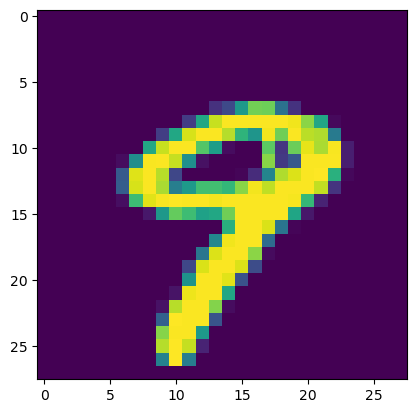

In [81]:
data = test_data[9] # this is already normalized
plt.imshow(data)

In [83]:
data.shape

(28, 28)

In [99]:
# we need data in the shape (1, 28, 28) for individual prediction
data = tf.expand_dims(data, axis=0)
data.shape

TensorShape([1, 28, 28])

In [103]:
y_prob  = final_model.predict(data)
y_prob

1/1 [==============================] - 0s 15ms/step


array([[2.8289482e-12, 1.4190151e-17, 4.1970018e-14, 1.2529690e-10,
        7.3617066e-08, 1.3777965e-12, 2.8783391e-21, 1.0051896e-08,
        7.4452727e-12, 9.9999988e-01]], dtype=float32)

We can observe that the outputs are probabilities, representing the probability of each digit.

In [106]:
y_pred = y_prob.argmax(axis=1)
y_pred

array([9])

<a name="8"></a>
## <font color='red'> <b> 8. Analysys </font> </b>

Instance 62: True class: 8, Predcited class: 2
Instance 116: True class: 4, Predcited class: 9
Instance 152: True class: 9, Predcited class: 8
Instance 248: True class: 4, Predcited class: 2
Instance 260: True class: 6, Predcited class: 0


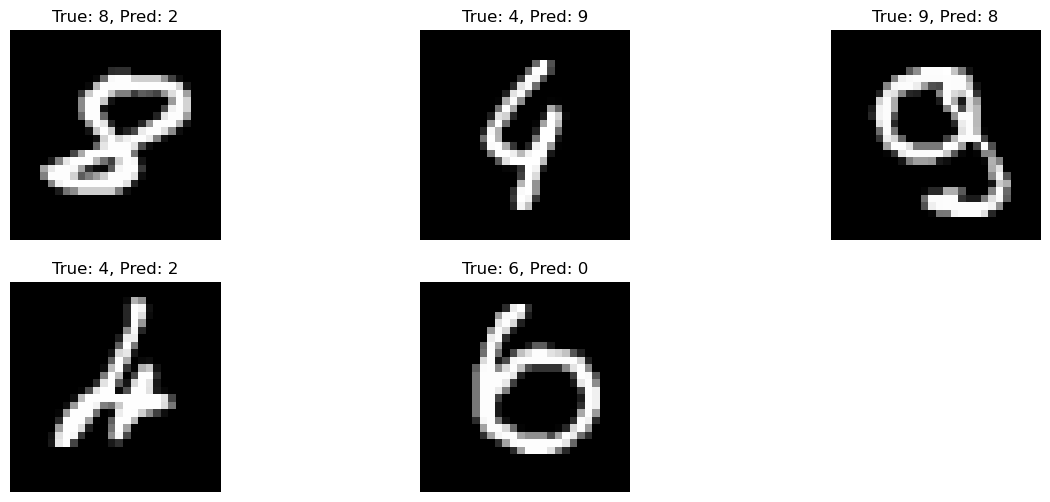

In [109]:
# Find indices of bad predictions
incorrect_indices = np.where(test_labels != y_preds)[0]

# Visualize
num_samples_to_visualize = min(5, len(incorrect_indices))
num_columns = 3
num_rows = (num_samples_to_visualize + 1) // num_columns
plt.figure(figsize=(15, 3 * num_rows))

for i in range(num_samples_to_visualize):
    index = incorrect_indices[i]
    
    # 
    true_class = test_labels[index]
    predicted_class = y_preds[index]
    print(f'Instance {index + 1}: True class: {true_class}, Predcited class: {predicted_class}')

    # 
    plt.subplot(num_rows, num_columns, i + 1)
    plt.imshow(test_data[index], cmap='gray') 
    plt.title(f'True: {true_class}, Pred: {predicted_class}')
    plt.axis('off')
